# 训练-测试 模型



## 环境要求
* Python 3.7
* Pytorch 1.7
* CUDA 11.1

可以运行bash命令安装依赖
```bash
pip install -r requirements.txt
```

## 使用到的数据集
* ISTD [[link]](https://github.com/DeepInsight-PCALab/ST-CGAN)  
* ISTD+ [[link]](https://github.com/cvlab-stonybrook/SID)
* SRD [[Training]](https://drive.google.com/file/d/1W8vBRJYDG9imMgr9I2XaA13tlFIEHOjS/view)[[Testing]](https://drive.google.com/file/d/1GTi4BmQ0SJ7diDMmf-b7x2VismmXtfTo/view)

## 预训练模型权重
* [ISTD](https://drive.google.com/file/d/1bHbkHxY5D5905BMw2jzvkzgXsFPKzSq4/view?usp=share_link) 
* [ISTD+](https://drive.google.com/file/d/10pBsJenoWGriZ9kjWOcE4l4Kzg-F1TFd/view?usp=share_link)
* [SRD]()

> 如果需要使用，请下载相应的预训练模型，并在test.py中修改weights路径。

## Test

> 可以直接测试预训练模型的性能,步骤：

1. 修改数据集和预训练模型的路径。需要在test.py中修改以下路径

```python
input_dir # 阴影图像路径 -- 第27行
weights # 预训练模型路径 -- 第31行
```

2. Test the model

```python
python test.py --save_images
```
输出结果在 `./results`.

## Train

1. 下载数据集并设置为以下结构
```
|-- ISTD_Dataset
    |-- train
        |-- train_A # shadow image
        |-- train_B # shadow mask
        |-- train_C # shadow-free GT
    |-- test
        |-- test_A # shadow image
        |-- test_B # shadow mask
        |-- test_C # shadow-free GT
```

2. 在option.py中修改以下项
```python
train_dir  # 训练集路径
val_dir   # 测试集路径
gpu: 0  # 模型使用的GPU，可以通过在此添加更多 GPU ID 来使用多个 GPU 进行训练。
```

3. Train the network
如果您想在256X256的图像上训练网络：
```python
python train.py --warmup --win_size 8 --train_ps 256
```
或者在原始分辨率上训练，例如 ISTD 的 480X640：
```python
python train.py --warmup --win_size 10 --train_ps 320
```


## 结果展示

### 下载数据集和代码

按照上面指引操作下载代码，和数据集。我这里只下载了ISTD数据集

文件如下图：

<img src="../images/model-result/DATASET.png" alt="DATASET" width="400px">

### 训练过程

如果你按照上面的指引设置好，运行的结果应该如下图：

<img src="../images/model-result/TRAIN.png" alt="TRAIN" width="800px">

我使用的是3090GPU，在ISTD上训练大概消耗17G显存

<img src="../images/model-result/GPU-MEM-USAGE.png" alt="GPU" width="800px">

### 测试过程

如果你按照上面的指引设置好，测试的结果应该如下图：

<img src="../images/model-result/TEST.png" alt="TEST" width="800px">

### 利用预训练模型的测试效果

我们下面展示两张图片的去阴影效果：

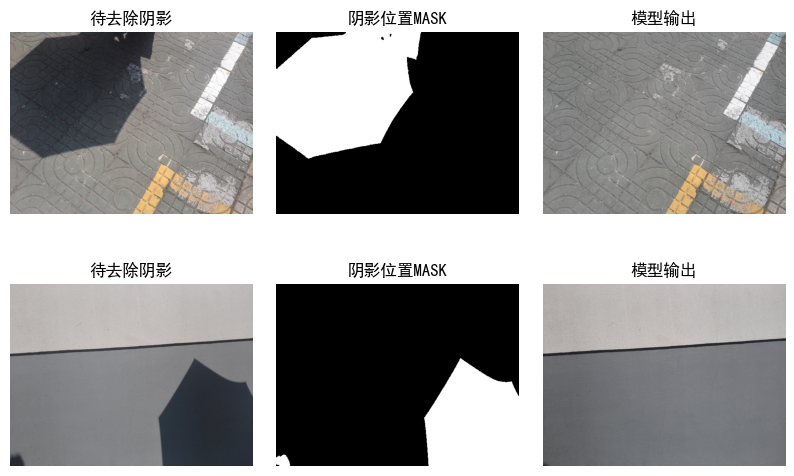

In [65]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'

# 创建2x5的子图网格
fig, axs = plt.subplots(2, 3,figsize=(10, 6))

# 指定每个子图的位置和标签
positions = [(0, 0, '待去除阴影'), (0, 1, '阴影位置MASK'), 
             (0, 2, '模型输出'),
             (1, 0, '待去除阴影'), (1, 1, '阴影位置MASK'), 
             (1, 2, '模型输出')
             ]

img_path = ['../images/model-result/A-100-1.png','../images/model-result/B-100-1.png','../images/model-result/C-100-1.png',
            '../images/model-result/A-101-1.png','../images/model-result/B-101-1.png','../images/model-result/C-101-1.png']
# 加载并显示每个子图的PNG图片
for i,position in enumerate(positions):
    path = img_path[i]
    img = plt.imread(path)
    if i==1 or i==4:
        axs[position[0], position[1]].imshow(img,cmap='gray')
    else:
        axs[position[0], position[1]].imshow(img)
    axs[position[0], position[1]].set_title(position[2])
    axs[position[0], position[1]].axis('off')

# 调整子图之间的间距和外边距
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.margins(0, 0)

# 展示图形
plt.show()

## 更改图片的掩码查看效果

> 我们还使用了不同的掩码来作为测试的输入，看看不同的掩码对于模型效果的影响

我们选择了五种掩码：
- 原始正确的掩码
- 全为255（8bit）的掩码
- 全为0的掩码
- 随机数掩码
- 原始掩码翻转的掩码

下面的代码是根据原始掩码获取不同对应掩码的过程

In [38]:

from PIL import Image
import numpy as np


# 读取图像
image_path = '../images/different-mask/100-1.png'  # 替换为你自己的图片路径
image = Image.open(image_path)

# 将图像转换为 numpy 数组
mask_array = np.array(image)

# 输出矩阵的形状
print(mask_array.shape)
print(mask_array.dtype)
# print(image_array[55])

mask_ones = np.full(mask_array.shape,255,dtype=np.uint8)
# print(img_ones[55])

mask_zeros = np.full(mask_array.shape,0,dtype=np.uint8)
# print(img_zeros[55])

mask_reverse = np.zeros(mask_array.shape).astype(np.uint8)
mask_reverse = np.where(mask_array==0,255,0)
# print(mask_reverse[55])

mask_random = (np.random.rand(*mask_array.shape)*255).astype(np.uint8)
# print(mask_random[0])

# 将矩阵转换为图像对象
# mask_ones = Image.fromarray(mask_ones)
# mask_ones.save('100-1-ones.png')
# mask_zeros = Image.fromarray(mask_zeros)
# mask_zeros.save('100-1-zeros.png')
# mask_reverse = Image.fromarray(mask_reverse.astype('uint8'))
# mask_reverse.save('./100-1-reverse.png')
# mask_random = Image.fromarray(mask_random)
# mask_random.save('100-1-random.png')

# mask_reverse.show()

(480, 640)
uint8


> 我们查看一下不同掩码的对于模型的输出影响

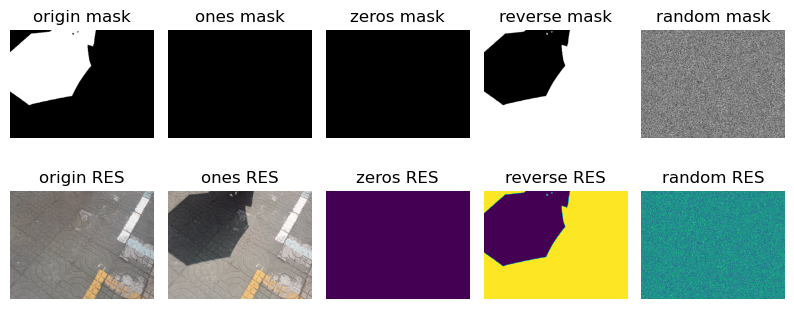

In [59]:
import matplotlib.pyplot as plt

# 创建2x5的子图网格
fig, axs = plt.subplots(2, 5,figsize=(10, 4))

# 指定每个子图的位置和标签
positions = [(0, 0, 'origin mask'), (0, 1, 'ones mask'), 
             (0, 2, 'zeros mask'), (0, 3, 'reverse mask'), 
             (0, 4, 'random mask'), (1, 0, 'origin RES'), 
             (1, 1, 'ones RES'), (1, 2, 'zeros RES'), 
             (1, 3, 'reverse RES'), (1, 4, 'random RES')]

img_path = [(0, 0, '../images/different-mask/100-1.png'), (0, 1, '../images/different-mask/100-1-ones.png'), 
             (0, 2, '../images/different-mask/100-1-zeros.png'), (0, 3, '../images/different-mask/100-1-reverse.png'), 
             (0, 4, '../images/different-mask/100-1-random.png'), (1, 0, '../images/different-mask/RES-100-1.png'), 
             (1, 1, '../images/different-mask/RES-100-1-ones.png'), (1, 2, '../images/different-mask/100-1-zeros.png'), 
             (1, 3, '../images/different-mask/100-1-reverse.png'), (1, 4, '../images/different-mask/100-1-random.png')]
# 加载并显示每个子图的PNG图片
for i,position in enumerate(positions):
    path = img_path[i][2]
    img = plt.imread(path)
    if i<5:
        axs[position[0], position[1]].imshow(img,cmap='gray')
    else:
        axs[position[0], position[1]].imshow(img)
    axs[position[0], position[1]].set_title(position[2])
    axs[position[0], position[1]].axis('off')

# 调整子图之间的间距和外边距
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.margins(0, 0)

# 展示图形
plt.show()

> 可以发现不同的MASK对模型的影响非常大，有些甚至会让模型输出无意义的图像。